In [24]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix


## Movielens full - EDA
a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

* Jag börjar med att undersöka vad datasetet har för columner med df.head och df.info()
* Samt så har jag läst på "Read me" filen som tillhör datasetet

In [25]:
df_movies= pd.read_csv("Data/ml-latest/movies.csv", index_col = 0)
df_movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [26]:
df_ratings= pd.read_csv("Data/ml-latest/ratings.csv", index_col = 0)
df_ratings.head()

,movieId,rating,timestamp
userId,,,
1,1,4.0,1225734739
1,110,4.0,1225865086
1,158,4.0,1225733503
1,260,4.5,1225735204
1,356,5.0,1225735119


In [27]:
# Jag tar df.info 
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86537 entries, 1 to 288983
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   86537 non-null  object
 1   genres  86537 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [28]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33832162 entries, 1 to 330975
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   rating     float64
 2   timestamp  int64  
dtypes: float64(1), int64(2)
memory usage: 1.0 GB


Jag ser att jag behöver splita cellerna så att i genders och film titel delas upp.

In [29]:
df_movies = df_movies.assign(year=df_movies ['title'].str.extract(r'\((\d{4})\)'), title=df_movies ['title'].str.replace(r'\(\d{4}\)', '').str.strip())

df_movies['genres'] = df_movies['genres'].str.split('|')
df_movies= df_movies.explode('genres')

df_movies.head()


,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure,1995
1,Toy Story (1995),Animation,1995
1,Toy Story (1995),Children,1995
1,Toy Story (1995),Comedy,1995
1,Toy Story (1995),Fantasy,1995


b) Vilka är de 10 filmerna med flest ratings?

In [30]:
# Utför sammanslagning samt kolumner samt återställt indexet till 'movieId'
merged_df = pd.merge(df_ratings, df_movies, on='movieId')[['movieId', 'title', 'genres', 'rating', 'timestamp']]
merged_df = merged_df.set_index('movieId').reset_index()

# Gruppera efter filmtitel och räkna antalet betyg för varje film
top_movies = merged_df.groupby('title').size().reset_index(name='rating_count')

# Sortera resultaten i fallande ordning baserat på antalet betyg och välj de 10 första raderna
top_10_movies = top_movies.sort_values(by='rating_count', ascending=False).head(10)

print(top_10_movies)


                                  title  rating_count
32908                  Inception (2010)        455392
24766               Forrest Gump (1994)        454324
52643               Pulp Fiction (1994)        435024
76042                  Toy Story (1995)        384065
58370                      Shrek (2001)        351174
23600                 Fight Club (1999)        344828
35217              Jurassic Park (1993)        332104
42352                Matrix, The (1999)        321168
39048             Lion King, The (1994)        321054
58573  Silence of the Lambs, The (1991)        305406


c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [34]:
avg_rating_top_10 = top_10_movies.merge(merged_df, on='title').groupby('title')['rating'].mean()

print(avg_rating_top_10)

title
Fight Club (1999)                   4.236019
Forrest Gump (1994)                 4.068189
Inception (2010)                    4.176187
Jurassic Park (1993)                3.689013
Lion King, The (1994)               3.833477
Matrix, The (1999)                  4.160631
Pulp Fiction (1994)                 4.191778
Shrek (2001)                        3.748595
Silence of the Lambs, The (1991)    4.150287
Toy Story (1995)                    3.893508
Name: rating, dtype: float64


d) Gör en plot över årtal och antalet filmer representerade i datasetet.

Jag tar filtrerar ut så att ploten bara visar filmer från 1950 och framåt

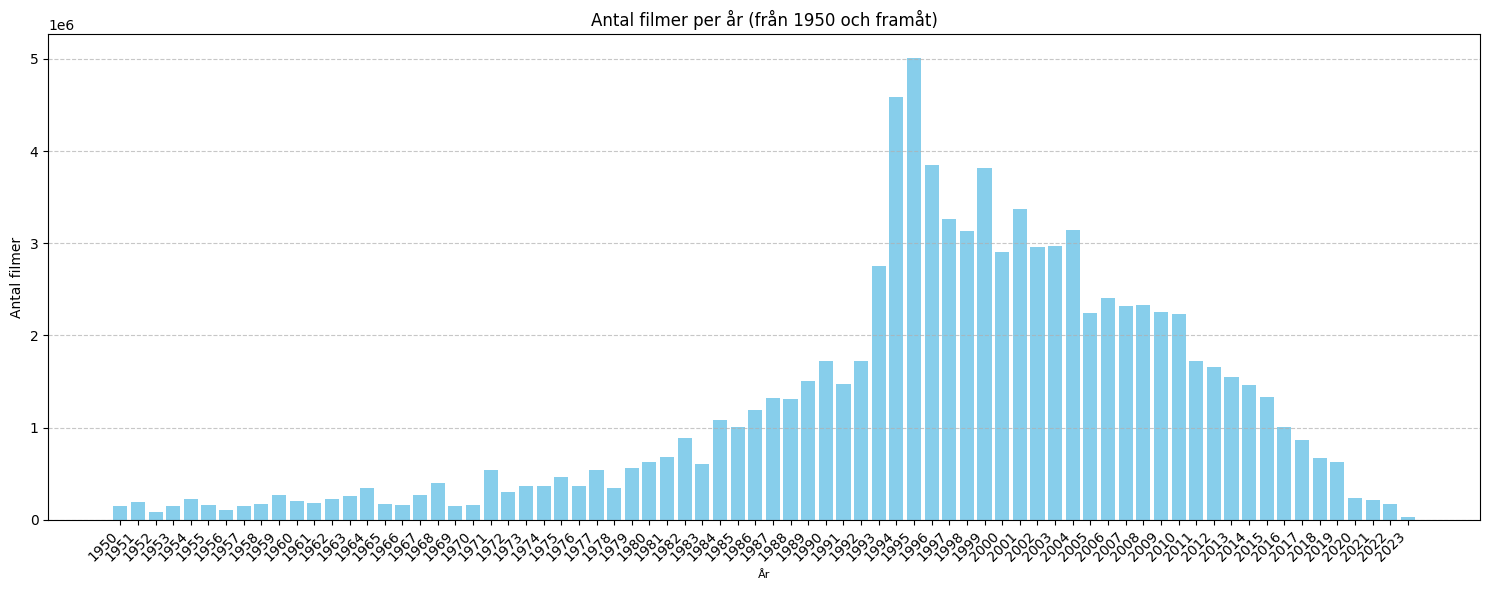

In [33]:
# Filtrera filmer från 1950 och framåt
merged_df_filtered = merged_df[merged_df['year'].astype(float) >= 1950]

# Räkna antalet filmer per år
movies_per_year = merged_df_filtered.groupby('year').size()

#
plt.figure(figsize=(15, 6))
bars = plt.bar(movies_per_year.index, movies_per_year, color='skyblue')

plt.title('Antal filmer per år (från 1950 och framåt)')
plt.xlabel('År', fontsize=8)
plt.ylabel('Antal filmer')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



e) Gör en plot över antalet ratings mot movieId.

f) Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över
dessa.

1.2 Skapa gles matris

Likt i videon i uppgift 1.0 skapade du en pivottabell av dataframet med index: "movieId", columns: "userId"
och values: "ratings". Denna pivottabell är dock "dyr" att skapa och förmodligen kommer inte din dator att
klara av skapa den om du inte filtrerar bort viss data. Fundera ut ett lämpligt sätt att filtrera ditt dataset,
pröva dig fram och motivera.#

Skapa en gles (sparse) matris av denna pivottabell mha scipy.sparse.csc_matrix(). Vill du använda
dig av all data går det också att lösa, men du behöver lösa hur du skapar den glesa matrisen utan pandas
pivot-tabell.

 1.3 Recommender system

Skapa ett recommender system med KNN och låt systemet ta input från användaren och skriva ut top 5
rekommenderade filmerna, baserat på användarens sökquery. Observera att det finns ett logiskt fel i
videon som gör att rekommendationerna inte blir så bra, försök hitta felet och åtgärda det.

a) Beskriv med ord hur ditt system fungerar.

b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa.

